In [2]:
import sys
import torch
import cv2 as cv
import numpy as np
#sys.path.insert(1, './PWC-Net/PyTorch/')

from models.PWC_Net.PyTorch.models.PWCNet import PWCDCNet
from utils.plotting import *
from models.flownet2.utils.flow_utils import *
from math import ceil

In [3]:
net = PWCDCNet()

./PWC-Net/PyTorch/models/PWCNet.py:141: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data, mode='fan_in')


In [4]:
state_dict = torch.load("PWC-Net/PyTorch/pwc_net.pth.tar")

net.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
img = torch.load('/home/till/uni/masterArbeit/Tests/img.pth')
seg = torch.load('/home/till/uni/masterArbeit/Tests/seg.pth')

In [6]:
fix = 12 ; mov = 9

img_fixed = img[fix:fix + 1, :, :].float() / 255
img_moving = img[mov:mov + 1, :, :].float() / 255
H, W = img_fixed.shape[-2:]

divisor = 64
H_ = int(ceil(H/divisor) * divisor)
W_ = int(ceil(W/divisor) * divisor)

img_fixed.shape

torch.Size([1, 320, 256])

PWCNet expects RGB input!

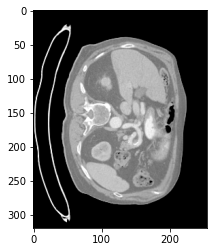

In [79]:
img_fixed_rgb = cv.cvtColor(img_fixed.reshape(H_,W_).numpy(), cv.COLOR_GRAY2RGB)
img_moving_rgb = cv.cvtColor(img_moving.reshape(H_,W_).numpy(), cv.COLOR_GRAY2RGB)
plt.imshow(img_fixed_rgb)

Preprocessing to get the right shape

In [80]:
img_1 = img_fixed_rgb[:, :, ::-1].transpose(2,0,1)
img_2 = img_moving_rgb[:, :, ::-1].transpose(2,0,1)
img_1.dtype

dtype('float32')

In [81]:
images = torch.from_numpy(np.asarray([img_1,img_2])) #np.asarray([img_fixed_rgb, img_moving_rgb])
for i, im in enumerate(images):
    
    images[i] = images[i].expand(1,images[i].shape[0],images[i].shape[1],images[i].shape[2])
    print(images[i].expand(1,images[i].shape[0],images[i].shape[1],images[i].shape[2]).shape)
    
images.unsqueeze(0).shape

torch.Size([1, 3, 320, 256])
torch.Size([1, 3, 320, 256])


torch.Size([1, 2, 3, 320, 256])

Somehow, the net expects two images, that are next to each other channel wise, to process them. 

So an array of [Batchsize, 2* channel, H, W] Wheren Batchsize is 1 and every image has 3 channels

In [82]:
net.cuda()
flo = net(images.resize(1,6,H,W).cuda())

torch.Size([1, 81, 5, 4])


In [83]:
print(flo[0].shape)
print(flo[1].shape)
flo = flo[0]
flo = flo.cpu().data.numpy()
flo.shape

torch.Size([1, 2, 80, 64])
torch.Size([1, 2, 40, 32])


(1, 2, 80, 64)

In [84]:
#flo = np.swapaxes(np.swapaxes(flo, 0, 1), 1, 2)#print(flo.shape)
flo = np.swapaxes(flo, 0, 1)
flo.shape

(2, 1, 80, 64)

In [85]:
u_ = cv.resize(flo[0,:,:,0],(W,H))
v_ = cv.resize(flo[1,:,:,1],(W,H))
u_ *= W
v_ *= H
flo = np.dstack((u_,v_))

In [86]:
flo.shape

(320, 256, 2)

In [87]:
floIm = flow2img(flo)
floIm.shape

(320, 256, 3)

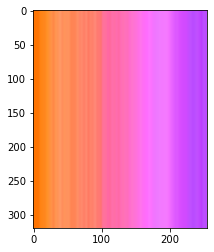

In [88]:
plt.imshow(floIm)

## This result above does not look promissing. Let us try the two images, that are available in the repo and try to reproduce the flow file, that was also delivered with it

In [146]:
im1 = cv.imread("PWC-Net/PyTorch/data/frame_0010.png")
im1.shape

(436, 1024, 3)

In [137]:
im_all = [cv.imread("PWC-Net/PyTorch/data/frame_0010.png"),cv.imread("PWC-Net/PyTorch/data/frame_0011.png")]
im_all = [im[:, :, :3] for im in im_all]

In [138]:
divisor = 64.
H = im_all[0].shape[0]
W = im_all[0].shape[1]

H_ = int(ceil(H/divisor) * divisor)
W_ = int(ceil(W/divisor) * divisor)
for i in range(len(im_all)):
	im_all[i] = cv.resize(im_all[i], (W_, H_))

In [139]:
for _i, _inputs in enumerate(im_all):
	im_all[_i] = im_all[_i][:, :, ::-1]
	im_all[_i] = 1.0 * im_all[_i]/255.0
	
	im_all[_i] = np.transpose(im_all[_i], (2, 0, 1))
	im_all[_i] = torch.from_numpy(im_all[_i])
	im_all[_i] = im_all[_i].expand(1, im_all[_i].size()[0], im_all[_i].size()[1], im_all[_i].size()[2])	
	im_all[_i] = im_all[_i].float()

In [140]:
#im_all = torch.autograd.Variable(torch.cat(im_all,1).cuda())
im_all = torch.cat(im_all,1).cuda()
print(im_all.shape)

torch.Size([1, 6, 448, 1024])


In [141]:
net = net.cuda()
net.eval()

flo = net(im_all)
print("Output: ", flo.shape)
flo = flo[0] * 20.0
flo = flo.cpu().data.numpy()
print("First entry to numpy: ", flo.shape)
# scale the flow back to the input size 
flo = np.swapaxes(np.swapaxes(flo, 0, 1), 1, 2) # 
u_ = cv.resize(flo[:,:,0],(W,H))
v_ = cv.resize(flo[:,:,1],(W,H))
u_ *= W/ float(W_)
v_ *= H/ float(H_)
flo = np.dstack((u_,v_))
print("Stacked: ", flo.shape)

torch.Size([1, 81, 7, 16])
Output:  torch.Size([1, 2, 112, 256])
First entry to numpy:  (2, 112, 256)
Stacked:  (436, 1024, 2)


In [142]:
flow_rec = flow2img(flo)

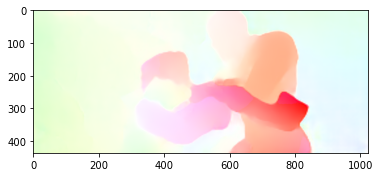

In [143]:
plt.imshow(flow_rec)

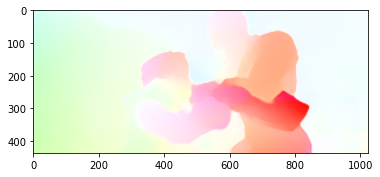

In [144]:
flow_original = readFlow("PWC-Net/PyTorch/tmp/reference_frame_0010.flo")
flow_im_orig = flow2img(flow_original)
plt.imshow(flow_im_orig)

## So that seemed to work. However, with the medical data it does not. 
Ideas why it does not work, include:
- openCV function to convert gray to rgb. Maybe a better way to create a suitable image is to just double the image in all three channels.
- Right sizing. The output of the pngs is not remotely close to the output from the medical data. 

# Let's explore these options

Explore the first option. First, reshape the tensor and convert it to numpy

In [7]:
img_fixed = img[fix:fix + 1, :, :].float() / 255
img_moving = img[mov:mov + 1, :, :].float() / 255

divisor = 64
H_ = int(ceil(H/divisor) * divisor)
W_ = int(ceil(W/divisor) * divisor)

C,H,W = img_fixed.shape
img_fixed = img_fixed.reshape(H,W,C).numpy()
img_moving = img_moving.reshape(H,W,C).numpy()

img_fixed = np.concatenate([img_fixed,img_fixed,img_fixed],2) 
img_moving = np.concatenate([img_moving,img_moving,img_moving],2)
img_fixed.shape

(320, 256, 3)

In [8]:
images = [img_fixed, img_moving]
for i in range(len(images)):
    images[i] = cv.resize(images[i], (W_, H_))

In [9]:
for _i, _inputs in enumerate(images):
    images[_i] = images[_i][:, :, ::-1]
    #images[_i] = 1.0 * images[_i]/255.0
    
    images[_i] = np.transpose(images[_i], (2, 0, 1))
    
    # Running into a "negative number" error in th line below, need to change that
    # The error suggested to use the copy() function as a workaround. 
    images[_i] = torch.from_numpy(images[_i].copy())
    # Worked ¯\_(ツ)_/¯
    
    images[_i] = images[_i].expand(1, images[_i].size()[0], images[_i].size()[1], images[_i].size()[2])	
    images[_i] = images[_i].float()

In [10]:
images = torch.cat(images,1).cuda()
images.shape

torch.Size([1, 6, 320, 256])

In [11]:
net = net.cuda()
net.eval()

flo = net(images)
flo = flo[0] * 20.0
flo = flo.cpu().data.numpy()

# scale the flow back to the input size 
flo = np.swapaxes(np.swapaxes(flo, 0, 1), 1, 2) # 
u_ = cv.resize(flo[:,:,0],(W,H))
v_ = cv.resize(flo[:,:,1],(W,H))
u_ *= W/ float(W_)
v_ *= H/ float(H_)
flo = np.dstack((u_,v_))

torch.Size([1, 81, 5, 4])


/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


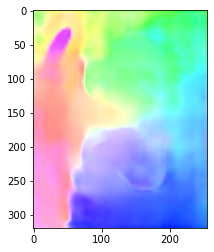

In [12]:
flow_new = flow2img(flo)
plt.imshow(flow_new)
plt.imsave("PWC-FlowVis.png", flow_new)

## WAY Better!!
Shape is different, and also the RGB channels were changed to onyl be concatenated gray images